# CHICAGO FOOD INSPECTIONS 📋

Esta información se deriva de inspecciones de restaurantes y otros establecimientos de comida en Chicago desde el 1 de enero de 2010 hasta el presente. Las inspecciones las realiza el personal del Programa de Protección de Alimentos del Departamento de Salud Pública de Chicago utilizando un procedimiento estandarizado. Los resultados de la inspección se ingresan en una base de datos, luego son revisados y aprobados por un pasante de salud ambiental con licencia del estado de Illinois (LEHP, por sus siglas en inglés).

Este `notebook` muestra de manerá rápida un Análisis exploratorio inicial de los datos.

A continuación procederemos a importar las librerías que utilizaremos.

Los datos están contenidos en este [Drive](https://drive.google.com/drive/folders/1mC9ansiVw8bXaAw0xf9Q7YKlzfuBhYUr?usp=sharing) 

**Nota:** usar `!pip install geopandas` y/o `!pip install contextily` y/o `!pip install descartes` 

## 0. Cargando librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geopandas
!pip install contextily
!pip install descartes

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import geopandas as gpd
import contextily as ctx

from geopandas import GeoDataFrame as gdf

## 1. Descarga y revisión de las variables
A continuación montaremos el drive en este entorno colaborativo, para después cargar nuestros datos y hacer una inspección breve.

In [4]:
!ls drive/MyDrive/Colab\ Notebooks/data*

Food_Inspections.csv  ward1998.dbf  ward1998.prj  ward1998.shp	ward1998.shx


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Food_Inspections.csv")
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2472776,HOT DOG STATION,HOT DOG STATION,2153527.0,Restaurant,Risk 1 (High),4742 N KIMBALL AVE,CHICAGO,IL,60625.0,01/15/2021,Canvass Re-Inspection,Pass,56. ADEQUATE VENTILATION & LIGHTING; DESIGNATE...,41.967856,-87.713497,"(-87.7134972229382, 41.96785571643644)"
1,2472716,TIERRA MEXICANA,TIERRA MEXICANA,2483240.0,Restaurant,Risk 1 (High),5423 W BELMONT AVE,CHICAGO,IL,60641.0,01/14/2021,Canvass,Out of Business,NaN,41.938518,-87.762522,"(-87.76252172746399, 41.938517967432716)"
2,2472708,"AQUA FOOD & LIQUOR, INC.","AQUA FOOD & LIQUOR, INC.",2762442.0,Grocery Store,Risk 3 (Low),503 N LaSalle DR,Chicago,IL,60654.0,01/14/2021,License,Pass w/ Conditions,NaN,41.890917,-87.632414,"(-87.63241429043457, 41.890917250209725)"
3,2472722,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,CHICAGO,IL,60630.0,01/14/2021,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.972349,-87.746825,"(-87.74682508578468, 41.97234928256036)"
4,2472698,"LINEAGE LOGISTICS, PFS, LLC","LINEAGE LOGISTICS, PFS, LLC",2762846.0,NaN,Risk 3 (Low),4500 W ANN LURIE PL,CHICAGO,IL,60632.0,01/14/2021,License,Not Ready,NaN,41.816288,-87.736023,"(-87.73602287216964, 41.81628771057973)"


In [6]:
len(data)

215130

In [7]:
data.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2487
License #             17
Facility Type       4892
Risk                  69
Address                0
City                 158
State                 50
Zip                   52
Inspection Date        0
Inspection Type        1
Results                0
Violations         57447
Latitude             710
Longitude            710
Location             710
dtype: int64

A continuación un diagrama para visualizar mejor esto.

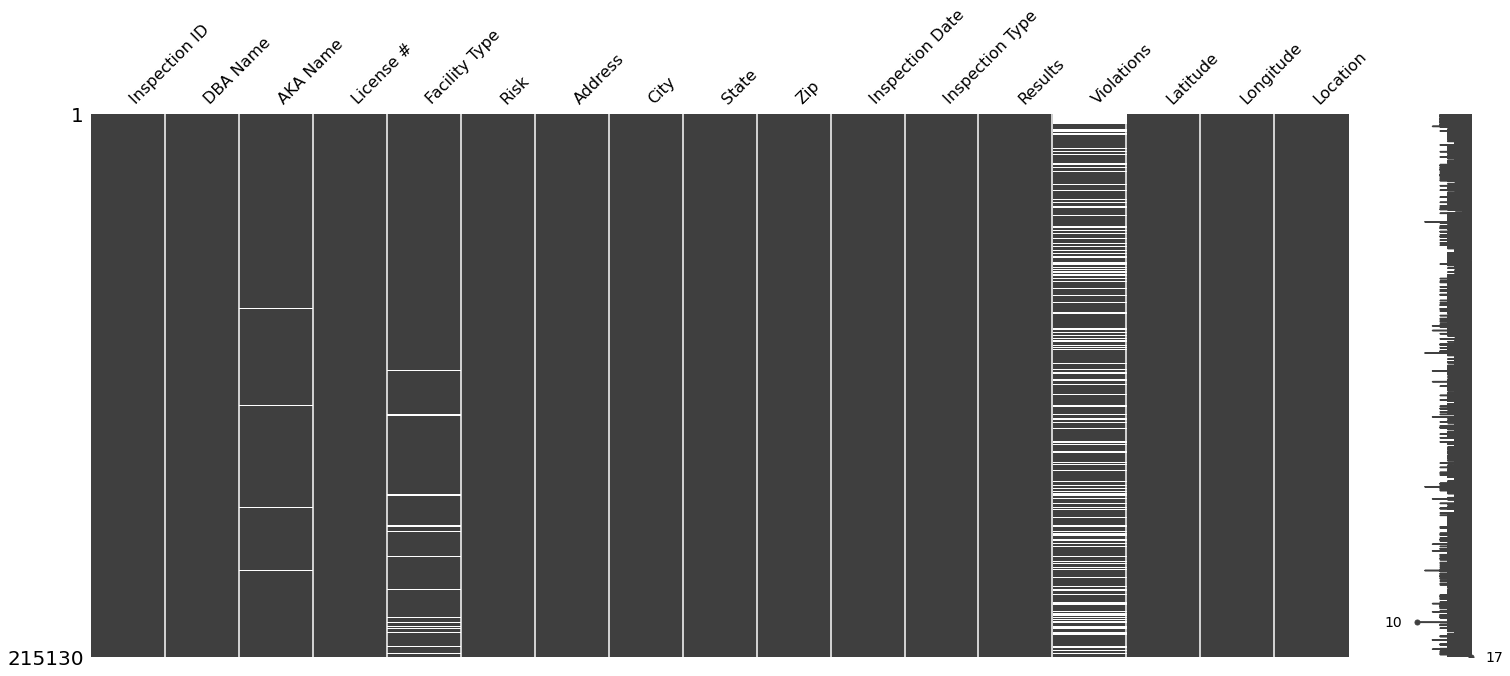

In [8]:
msno.matrix(data)

In [9]:
data = data.dropna(subset = ['Violations','Facility Type','Latitude','Longitude','AKA Name'])
data.isnull().sum()

Inspection ID       0
DBA Name            0
AKA Name            0
License #          11
Facility Type       0
Risk                1
Address             0
City               69
State              27
Zip                13
Inspection Date     0
Inspection Type     0
Results             0
Violations          0
Latitude            0
Longitude           0
Location            0
dtype: int64

In [10]:
len(data)

155949

In [11]:
data.describe(exclude=[np.number])

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Results,Violations,Location
count,155949,155949,155949,155948,155949,155880,155922,155949,155949,155949,155949,155949
unique,22516,21808,423,3,16274,14,1,2755,57,6,155012,15577
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,09/29/2016,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,"(-87.91442843927047, 42.008536400868735)"
freq,2350,2903,107267,117792,2220,155516,155922,111,86187,85861,11,2226


## 2. Análisis multivariado.

Este análisis se enfoca primero a hacer una revisión por fechas y después a una inspección geo espacial.

Primero, separaremos las fechas en, día, mes y año.

In [12]:
data['month'] = data['Inspection Date'].apply(lambda x:x.split('/')[0])
data['day'] = data['Inspection Date'].apply(lambda x:x.split('/')[1])
data['year'] = data['Inspection Date'].apply(lambda x:x.split('/')[2].split('T')[0])

Text(0.5, 0, 'month')

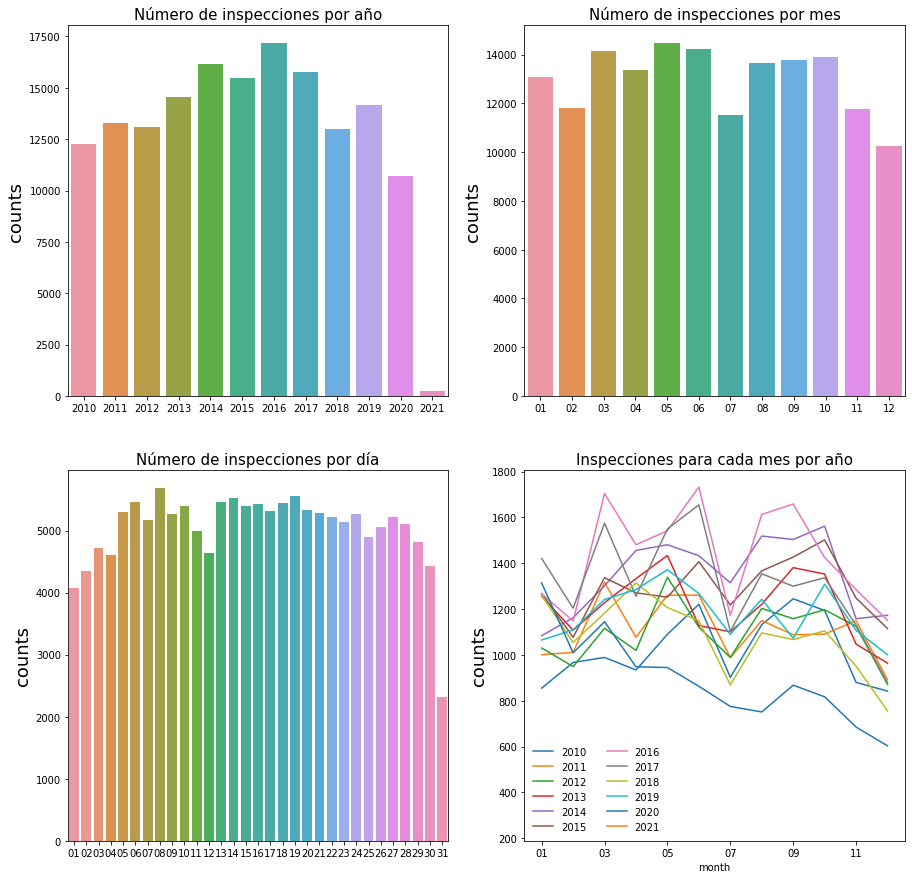

In [13]:
fig,ax=plt.subplots(2,2,figsize=(15,15))
x=data.year.value_counts().index
y=data.year.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,0],order=x.sort_values())
ax[0,0].set_title("Número de inspecciones por año",size=15)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

x=data.month.value_counts().index
y=data.month.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,1],order=x.sort_values())
ax[0,1].set_title("Número de inspecciones por mes",size=15)
ax[0,1].set_ylabel('counts',size=18)
ax[0,1].set_xlabel('')

x=data.day.value_counts().index
y=data.day.value_counts()
sns.barplot(x=x,y=y,ax=ax[1,0],order=x.sort_values())
ax[1,0].set_title("Número de inspecciones por día",size=15)
ax[1,0].set_ylabel('counts',size=18)
ax[1,0].set_xlabel('')

data.groupby(['year','month'])['Inspection ID'].agg('count').unstack('year').plot(ax=ax[1,1])
ax[1,1].set_title("Inspecciones para cada mes por año",size=15)
ax[1,1].legend(loc='lower left', frameon=False, ncol=2)
ax[1,1].set_ylabel('counts',size=18)
ax[1,1].set_xlabel('month')

La gráfica de la izquierda superior nos muestra que las inspecciones se concentraron entre 2014 y 2018, siendo 2016 el año en que se reporta el mayor número. Es claro el impacto de la pandemia en la frecuencia de las inspecciones, puesto que durante 2020 se reporta un descenso notable de éstas.

La gráfica superior derecha nos muestra las inspecciones por mes. No se observa una tendencia clara, sin embargo podemos observar que en los meses de mayo y junio se concentra el mayor número de inspecciones y durante diciembre este número disminuye.

La gráfica inferior izquierda muestra el número de inspecciones por día del mes. La tendencia no es clara, sin embargo destaca que el día 31 existen menos registros, lo que puede deberse a que no todos los meses tienen este día.

La gráfica de la derecha inferior muestra la relación entre año y mes de los registros. Es notorio que los picos son consistentes entre años, apesar de encontrarse en distintos niveles según el año. Durante 2020 tenemos el menor número de registros mismo que como ya mencionamos puede deberse a un menor número de inspecciones a consecuencia de la contingencia sanitaria.

## 3. Análisis Geográfico
Descargamos los datos con información de los polígonos con límites geográficos de Chicago.

Fuente: https://www.lib.uchicago.edu/e/collections/maps/uofcgis.html

In [14]:
ward1998 = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/data/ward1998.shp")


Eliminamos las filas que no contengan información numérica de la columna "Latitude"

In [15]:
data = data[pd.to_numeric(data['Latitude'], errors='coerce').notnull()]

Preparamos la base para la ubicación de los puntos donde se realizaron inspecciones con información de las columnas "Latitude" e "Longitude".

In [16]:
points= gdf(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

Presentamos la visualización de la base, una vez acondicionada para ubicar los puntos. La información se encuentra contenida en la columna "geometry".

In [17]:
points[:3]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,month,day,year,geometry
0,2472776,HOT DOG STATION,HOT DOG STATION,2153527.0,Restaurant,Risk 1 (High),4742 N KIMBALL AVE,CHICAGO,IL,60625.0,01/15/2021,Canvass Re-Inspection,Pass,56. ADEQUATE VENTILATION & LIGHTING; DESIGNATE...,41.967856,-87.713497,"(-87.7134972229382, 41.96785571643644)",01,15,2021,POINT (-87.71350 41.96786)
3,2472722,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,CHICAGO,IL,60630.0,01/14/2021,Canvass,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.972349,-87.746825,"(-87.74682508578468, 41.97234928256036)",01,14,2021,POINT (-87.74683 41.97235)
6,2472655,GOLD COAST MARKET,GOLD COAST MARKET,2762157.0,Grocery Store,Risk 2 (Medium),71-73 W CHICAGO AVE,CHICAGO,IL,60654.0,01/13/2021,License Re-Inspection,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.896529,-87.630992,"(-87.63099243940756, 41.8965294551304)",01,13,2021,POINT (-87.63099 41.89653)


Visualización de los datos que contiene información sobre los polígonos de Chicago

In [18]:
ward1998[:3]

,WARD,COUNT,geometry
0,10,46,"POLYGON ((-87.52494 41.70264, -87.52502 41.701..."
1,11,54,"POLYGON ((-87.65534 41.80873, -87.65535 41.808..."
2,12,30,"POLYGON ((-87.67976 41.83914, -87.67795 41.835..."


Se transforman los datos a crs paratener una base para el mapa

In [19]:
ward1998 = ward1998.to_crs(epsg=3857)

In [20]:
points.crs = "EPSG:4326"
points = points.to_crs(epsg=3857)

Ahora, visualicemos nuestro mapa

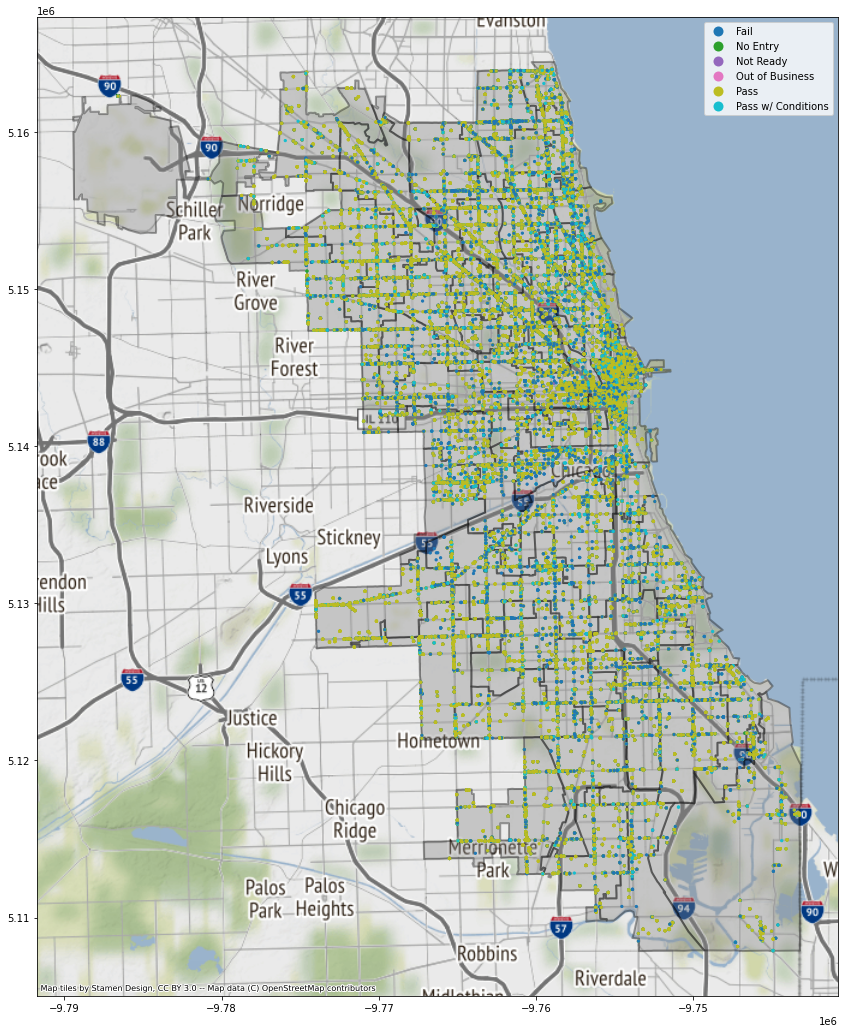

In [21]:
ax = ward1998.plot(figsize=(18, 18), alpha=0.35, edgecolor='black',color='gray', linewidth=2)
points.plot(ax=ax, markersize=5, marker="o", column='Results',legend=True)
ctx.add_basemap(ax)

El mapa muestra una concentración de inspecciones en la zona centro de Chicago. Los resultados más comunes son inspecciones aprobadas "Pass", seguidas de reprobadas "Fail". En tercer lugar, aparecen las inspecciones aprobadas con condiciones "Pass w/Conditions". Asimismo, podemos recalcar que el número de inspecciones aprobadas es casi tres veces el número de inspecciones reprobadas. Otro aspecto que llama la atención es el trazo casi perfecto de calles y avenidas donde se ubican los establecimientos.

In [22]:
count = data['Results'].value_counts() 
print(count)

Pass                  85861
Fail                  37724
Pass w/ Conditions    31731
No Entry                540
Not Ready                63
Out of Business          30
Name: Results, dtype: int64


In [24]:
!pip freeze > requirements.txt